# Model tailoring tutorial

This tutorial will teach you how to customize existing models without the need for the base source code by using the existing pretrained resnet50 in the Pytorch library as a base architecture. This simulates a realistic situation where you only have the model but not the training code and want to build on existing work via transfer learning.

In [ ]:
import torch
from torchvision.models import resnet50, ResNet50_Weights

In this tutorial, we will use a tensor of shape `[2, 3, 224, 224]` (224 x 224 images with a batch size of 2) as an input. As the model is pretrained from the ImageNet dataset, the untailored model should return the output of 1000 class (a tensor of shape `[2, 1000]`) as an output.

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()
inputs = torch.ones((2, 3, 224, 224)).cuda() # dummy input

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 40.8MB/s]


In [ ]:
outputs = model(inputs)
print(outputs.shape)

torch.Size([2, 1000])


The existing model uses global average pooling and a linear layer after the output from the last convolutional layer to reduce the number of channels to 1000. However, for the sake of this tutorial, we will instead flatten the output from the last convolutional layer and condense it using a linear layer to reduce the number of classes into 10.

As shown below, by printing the model, the global average pooling and a linear layer are in the layers `avgpool` and `fc`, respectively.

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

To do as mentioned, we change the `fc` and `avgpool` layer to an identity layer instead so that these layers would do nothing.

In [ ]:
print(model.fc)
model.fc = torch.nn.Identity(2048)
print(model.avgpool)
model.avgpool = torch.nn.Identity(2048)

Linear(in_features=2048, out_features=1000, bias=True)
AdaptiveAvgPool2d(output_size=(1, 1))


By changing the the `fc` and `avgpool` layer to an identity layer, the model instead return a tensor of size 100352 (`[2048, 224//32, 224//32]`).

In [ ]:
outputs = model(inputs)
print(outputs.shape)

torch.Size([2, 100352])


By applying the `Linear` layer, the classes are now reduced to 10.

In [ ]:
new_dense = torch.nn.Linear(100352, 10).cuda()
outputs = new_dense(model(inputs))
print(outputs.shape)

torch.Size([2, 10])


<b>Tips0</b>: The nested layer, e.g., the last convolution layer, could be accessed using the following command.

In [ ]:
model.layer4[2].conv3

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

<b>Tips1</b> : The weight of each layer could be obtained and modified by using `model.named_parameters()`.

In [ ]:
for name, param in model.named_parameters():
    print(name, '\t', param.shape, '\t', param.mean())

conv1.weight 	 torch.Size([64, 3, 7, 7]) 	 tensor(-0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
bn1.weight 	 torch.Size([64]) 	 tensor(0.2574, device='cuda:0', grad_fn=<MeanBackward0>)
bn1.bias 	 torch.Size([64]) 	 tensor(0.2107, device='cuda:0', grad_fn=<MeanBackward0>)
layer1.0.conv1.weight 	 torch.Size([64, 64, 1, 1]) 	 tensor(-0.0044, device='cuda:0', grad_fn=<MeanBackward0>)
layer1.0.bn1.weight 	 torch.Size([64]) 	 tensor(0.1879, device='cuda:0', grad_fn=<MeanBackward0>)
layer1.0.bn1.bias 	 torch.Size([64]) 	 tensor(0.0309, device='cuda:0', grad_fn=<MeanBackward0>)
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3]) 	 tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
layer1.0.bn2.weight 	 torch.Size([64]) 	 tensor(0.1595, device='cuda:0', grad_fn=<MeanBackward0>)
layer1.0.bn2.bias 	 torch.Size([64]) 	 tensor(0.1063, device='cuda:0', grad_fn=<MeanBackward0>)
layer1.0.conv3.weight 	 torch.Size([256, 64, 1, 1]) 	 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
lay

<b>Tips2:</b> In case that you want you modify multiple layers programatically, you could access each layer using `model.modules()`.

In [ ]:
for module in model.modules():
  print(module.__class__.__name__, ': ', module)
  print("----")

ResNet :  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

<b>Tips3</b> : Actually, we can change the number of class of the pretrained ResNet 50 by using the input argument `num_classes`. But this is not as cool.

In [ ]:
model = resnet50(num_classes=3).cuda()
model(inputs).shape

torch.Size([2, 3])

## More convoluted modification

The methods above could also perform simple operations like altering and removing layers, however, it could not perform more complex operations like forking. In this part, we will show how to perform a more complex operation by modifying the model to return multi-scale predictions by introducing an additional head that performs global average pooling followed by a linear layer after the last convolutional layer of the fourth stage as shown in Figure below.

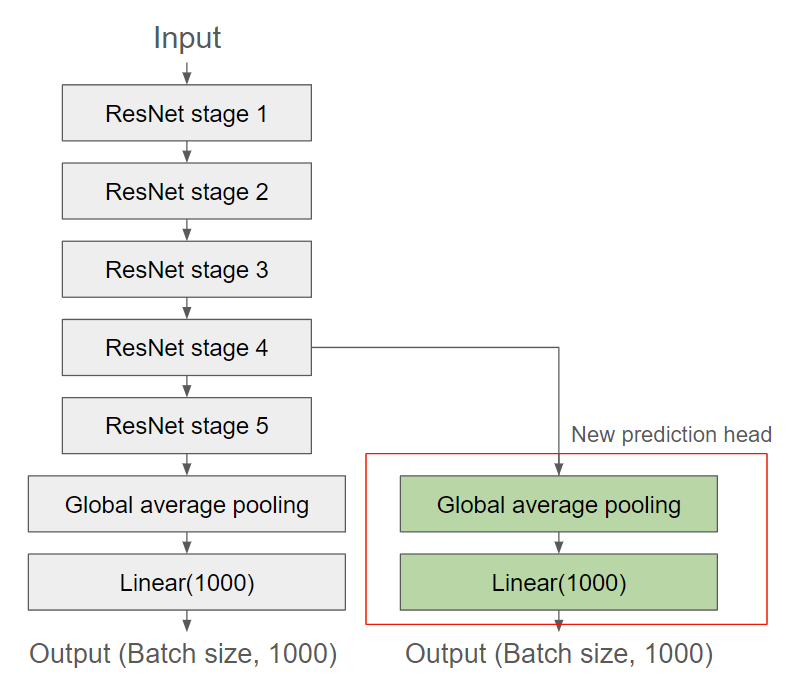

To do so, we will use the operation `register_forward_hook` to get the <b>intermediate output</b> of the last convolutional layer of stage 4.

In [ ]:
class MultiscaleModel(torch.nn.Module):
  def __init__(self):
    super(MultiscaleModel, self).__init__()
    #base_model is a standard imagenet pretrained model
    self.base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    self.activation = {}

    #layer for new prediction head
    self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1,1)) # Global average pooling layer
    self.fc = torch.nn.Linear(1024, 1000)

    def get_activation(name):
      def hook(model, input, output):
        self.activation[name] = output#.detach() # in case that you want to stop the gradient to flow through the hook you can detach()
      return hook

    # base_model.layer3[-1].relu is the last convolutional output of the stage 4
    self.base_model.layer3[-1].relu.register_forward_hook(get_activation('stage4'))

  def forward(self, inp):
    outputs = self.base_model(inp)
    stage_4_output = self.activation['stage4']
    print("stage 4 output : ",stage_4_output.shape)
    fourth_stage_head = self.global_avg_pool(stage_4_output)
    fourth_stage_head = fourth_stage_head.view(fourth_stage_head.shape[0], fourth_stage_head.shape[1]) # reshape from torch.Size([2, 1024, 1, 1]) to torch.Size([2, 1024])
    fourth_stage_head_output = self.fc(fourth_stage_head)
    return outputs, fourth_stage_head_output

In [ ]:
inputs = torch.ones((2, 3, 224, 224)).cuda() # dummy input
model = MultiscaleModel().cuda()

The model now returns two outputs : the one after stage 5 (last convolutional layer) and stage 4.

In [ ]:
output = model(inputs)
print(output[0].shape, output[1].shape)

stage 4 output :  torch.Size([2, 1024, 14, 14])
torch.Size([2, 1000]) torch.Size([2, 1000])
